In [1]:
import pandas as pd

import matplotlib.pyplot as plt


in this file, i used the previous final database and nuts_id combined df, which contained 4 clusters and all industries in each sector,
i grouped sectors in clusters, and have 8 sectors in each cluster,
now for each sector for example cement, i have total demand in germany of 20TWh, i distributed it in regions for co2 share,
the difference in this approach is each sector has almost the same emission per unit, which means now if we distribute total demand for that sector in to regions then its fine.
after this i added up all sectors demand in a region to get total demand of that region
then i made a comparison of all load profiles i downloaded for hotmaps to assume an average profile for missing sectors like glass and cement.
then i summed up all load profiles to get a sum_profile.
this sum profile is the unitless demand pattern of all sectors overall.
then it means that we can use these profiles for any region or for whole germany, because if i scale one regional demand using this profile, it just tell the pattern of demand over a year for that region.


In [2]:
df_cleaned = pd.read_csv('filtered_industrial_database.csv')

In [ ]:
df_emission_pivot = df_cleaned.pivot_table(
    index='Subsector',
    columns='Cluster',
    values='Emissions_ETS_2014',
    aggfunc='sum'
).reset_index()

# Step 3: Remove column name for cleaner output
df_emission_pivot.columns.name = None

# Step 4: Add total emissions column
df_emission_pivot['total_emission'] = df_emission_pivot[['DE2', 'DE9', 'DEA', 'DEE']].sum(axis=1)


In [ ]:
# Count number of industries (rows) per subsector per cluster
industry_counts = df_cleaned.groupby(['Cluster', 'Subsector']).size().reset_index(name='Industry_Count')
industry_counts

array(['DE2', 'DE9', 'DEA', 'DEE'], dtype=object)

In [70]:
# Add CO2 share column
grand_total_emission = df_emission_pivot['total_emission'].sum()
df_emission_pivot['CO2_share'] = df_emission_pivot['total_emission'] / grand_total_emission * 100
df_emission_pivot

,Subsector,DE2,DE9,DEA,DEE,total_emission,avg_emission,CO2_share
0,Cement,8663078.0,3109308.0,11364685.0,5629821.0,28766892.0,7191723.00,23.768963
1,Chemical industry,625901.0,2323751.0,9970320.0,5093427.0,18013399.0,4503349.75,14.883770
2,Glass,882236.0,315892.0,1299261.0,1244823.0,3742212.0,935553.00,3.092044
3,Iron and steel,560300.0,8233893.0,25057875.0,2278939.0,36131007.0,9032751.75,29.853644
4,Non-ferrous metals,175285.0,1074207.0,1569395.0,116723.0,2935610.0,733902.50,2.425580
5,Non-metallic mineral products,909274.0,321532.0,636013.0,575145.0,2441964.0,610491.00,2.017700
6,Paper and printing,1841313.0,877891.0,2228268.0,563724.0,5511196.0,1377799.00,4.553687
7,Refineries,6176859.0,3265125.0,7958355.0,6084505.0,23484844.0,5871211.00,19.404612


get all sector demands
divid it in regions according to CO2 (not sum)
sum all sectors in one region
that total is regional demand 


In [72]:
# Make a copy to avoid modifying the original
df_emission_demand = df_emission_pivot.copy()

# Step 1: Rename cluster columns to reflect CO₂ source
df_emission_demand.rename(columns={
    'DE2': 'DE2_CO2',
    'DE9': 'DE9_CO2',
    'DEA': 'DEA_CO2',
    'DEE': 'DEE_CO2'
}, inplace=True)

# Step 2: Estimated heat demand per sector in TWh (converted to GWh)
heat_demand_map = {
    'Chemical industry': 130_000000,
    'Iron and steel': 180_000000,
    'Non-ferrous metals': 10_000000,
    'Non-metallic mineral products': 65_000000,
    'Cement': 30_000000,
    'Glass': 20_000000,
    'Paper and printing': 25_000000,
    'Refineries': 120_000000
}

# Step 3: Add new columns for distributed demand based on CO₂ share
for cluster in ['DE2', 'DE9', 'DEA', 'DEE']:
    df_emission_demand[cluster] = df_emission_demand.apply(
        lambda row: (row[f'{cluster}_CO2'] / row['total_emission'] * heat_demand_map.get(row['Subsector'], 0))
        if row['total_emission'] > 0 else 0,
        axis=1
    )


In [73]:
df_emission_demand

,Subsector,DE2_CO2,DE9_CO2,DEA_CO2,DEE_CO2,total_emission,avg_emission,CO2_share,DE2,DE9,DEA,DEE
0,Cement,8663078.0,3109308.0,11364685.0,5629821.0,28766892.0,7191723.00,23.768963,9.034425e+06,3.242590e+06,1.185184e+07,5.871146e+06
1,Chemical industry,625901.0,2323751.0,9970320.0,5093427.0,18013399.0,4503349.75,14.883770,4.517034e+06,1.677016e+07,7.195430e+07,3.675850e+07
2,Glass,882236.0,315892.0,1299261.0,1244823.0,3742212.0,935553.00,3.092044,4.715051e+06,1.688264e+06,6.943813e+06,6.652873e+06
3,Iron and steel,560300.0,8233893.0,25057875.0,2278939.0,36131007.0,9032751.75,29.853644,2.791342e+06,4.102019e+07,1.248351e+08,1.135338e+07
4,Non-ferrous metals,175285.0,1074207.0,1569395.0,116723.0,2935610.0,733902.50,2.425580,5.970991e+05,3.659229e+06,5.346061e+06,3.976107e+05
5,Non-metallic mineral products,909274.0,321532.0,636013.0,575145.0,2441964.0,610491.00,2.017700,2.420298e+07,8.558513e+06,1.692934e+07,1.530916e+07
6,Paper and printing,1841313.0,877891.0,2228268.0,563724.0,5511196.0,1377799.00,4.553687,8.352602e+06,3.982307e+06,1.010791e+07,2.557176e+06
7,Refineries,6176859.0,3265125.0,7958355.0,6084505.0,23484844.0,5871211.00,19.404612,3.156176e+07,1.668374e+07,4.066463e+07,3.108986e+07


In [68]:
df_emission_demand[['Subsector', 'DE2', 'DE9', 'DEA', 'DEE']]

,Subsector,DE2,DE9,DEA,DEE
0,Cement,9.034425e+06,3.242590e+06,1.185184e+07,5.871146e+06
1,Chemical industry,4.517034e+06,1.677016e+07,7.195430e+07,3.675850e+07
2,Glass,4.715051e+06,1.688264e+06,6.943813e+06,6.652873e+06
3,Iron and steel,2.791342e+06,4.102019e+07,1.248351e+08,1.135338e+07
4,Non-ferrous metals,5.970991e+05,3.659229e+06,5.346061e+06,3.976107e+05
5,Non-metallic mineral products,2.420298e+07,8.558513e+06,1.692934e+07,1.530916e+07
6,Paper and printing,8.352602e+06,3.982307e+06,1.010791e+07,2.557176e+06
7,Refineries,3.156176e+07,1.668374e+07,4.066463e+07,3.108986e+07


now lets plot yearly load profiles of availabe sectors so we can assume the same profiles for cement, glass and refiniery

In [ ]:


# Load and prepare data
df = pd.read_csv('C:/Users/86435/project_h2/data/heat_demand/industry/load_profiles_sector_wise/combined_load_profiles.csv', parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)
existing_profiles = df[['load_paper', 'load_non_metalic', 'load_iron_steel', 'load_chemical']]
# Daily average smoothing
df['missing_sectors'] = existing_profiles.mean(axis=1)

In [ ]:
req_profiles= ['load_paper', 'load_non_metalic', 'load_iron_steel', 'load_chemical', 'missing_sectors']
df['sum_profiles'] = df[req_profiles].sum(axis=1)

In [ ]:
df

,month,day_type,hour,NUTS0_code,load_paper,load_non_metalic,load_iron_steel,load_chemical,load_food,sum_load,missing_sectors,sum_profiles
timestamp,,,,,,,,,,,,
2019-01-01 00:00:00,1,0,1,DE,114.480111,113.195206,112.918220,113.971763,114.535447,569.100747,113.641325,568.206625
2019-01-01 01:00:00,1,0,2,DE,114.480111,113.195206,112.918220,113.971763,114.535447,569.100747,113.641325,568.206625
2019-01-01 02:00:00,1,0,3,DE,114.480111,113.195206,112.918220,113.971763,114.535447,569.100747,113.641325,568.206625
2019-01-01 03:00:00,1,0,4,DE,114.480111,113.195206,112.918220,113.971763,114.535447,569.100747,113.641325,568.206625
2019-01-01 04:00:00,1,0,5,DE,114.480111,113.195206,112.918220,113.971763,114.535447,569.100747,113.641325,568.206625
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,12,0,20,DE,114.209737,115.837846,116.842303,115.320674,115.491809,577.702368,115.552640,577.763199
2019-12-31 20:00:00,12,0,21,DE,114.209737,115.837846,116.842303,115.320674,115.491809,577.702368,115.552640,577.763199
2019-12-31 21:00:00,12,0,22,DE,114.209737,115.837846,116.842303,115.320674,115.491809,577.702368,115.552640,577.763199


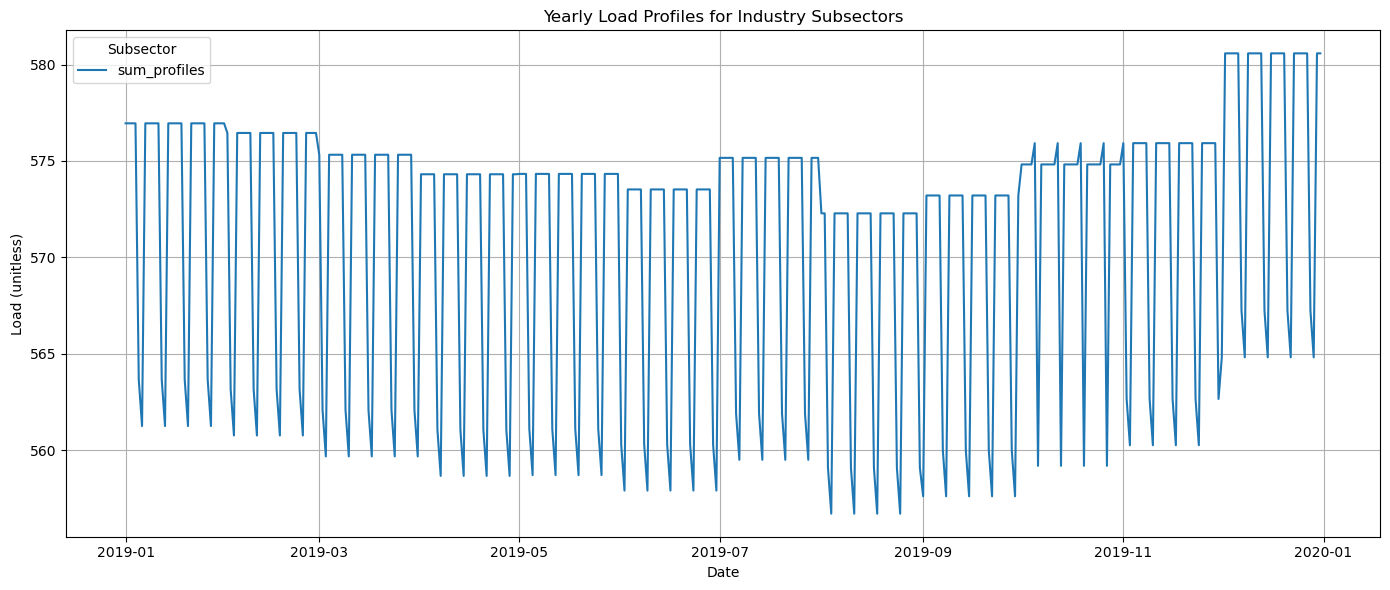

In [ ]:
# df_monthly = df[['load_paper', 'load_non_metalic', 'load_iron_steel', 'load_chemical', 'missing_sectors']].resample('M').mean()
df_monthly = df[['sum_profiles']].resample('D').mean()

# Plot
plt.figure(figsize=(14, 6))
for column in df_monthly.columns:
    plt.plot(df_monthly.index, df_monthly[column], label=column)

plt.title('Yearly Load Profiles for Industry Subsectors')
plt.xlabel('Date')
plt.ylabel('Load (unitless)')
plt.legend(title='Subsector')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
cluster_totals = df_emission_demand[['DE2', 'DE9', 'DEA', 'DEE']].sum()
# Create a new DataFrame for heat demand timeseries per cluster
cluster_profiles = pd.DataFrame(index=df.index)

# Use sum_profiles to distribute cluster totals across the year
for cluster in cluster_totals.index:
    cluster_profiles[cluster] = df['sum_profiles'] / df['sum_profiles'].sum() * cluster_totals[cluster]

# Rename index to 'timestamp'
cluster_profiles.index.name = 'timestamp'

In [ ]:
cluster_profiles

,DE2,DE9,DEA,DEE
timestamp,,,,
2019-01-01 00:00:00,9738.725211,10855.145357,32771.856899,12488.409453
2019-01-01 01:00:00,9738.725211,10855.145357,32771.856899,12488.409453
2019-01-01 02:00:00,9738.725211,10855.145357,32771.856899,12488.409453
2019-01-01 03:00:00,9738.725211,10855.145357,32771.856899,12488.409453
2019-01-01 04:00:00,9738.725211,10855.145357,32771.856899,12488.409453
...,...,...,...,...
2019-12-31 19:00:00,9902.519237,11037.716271,33323.041397,12698.449968
2019-12-31 20:00:00,9902.519237,11037.716271,33323.041397,12698.449968
2019-12-31 21:00:00,9902.519237,11037.716271,33323.041397,12698.449968


<Figure size 1200x800 with 0 Axes>

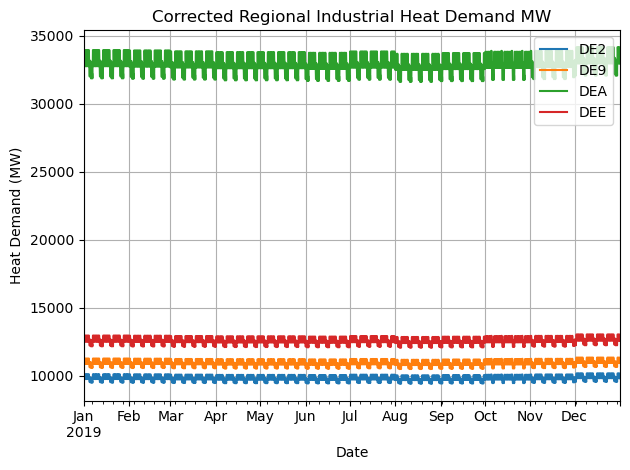

In [ ]:
plt.figure(figsize=(12, 8))
cluster_profiles.plot()

plt.title('Corrected Regional Industrial Heat Demand MW')
plt.xlabel('Date')
plt.ylabel('Heat Demand (MW)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
cluster_profiles.to_csv('C:/Users/86435/project_h2/data/heat_demand/industry/regional_demand.csv')


In [ ]:
# here we are checking for fuel demand and production, and getting avg of 5 values for eachs sector to see if all the per unit values for co2 emission on per unit fuel 
# consumption and co2 emission on per unit production are almost the same in each sector or not

# Step 1: Filter rows with valid emissions and fuel demand
df_fuel_demand = df_cleaned[pd.notnull(df_cleaned['Emissions_ETS_2014']) & pd.notnull(df_cleaned['Fuel_Demand'])]
df_production = df_cleaned[pd.notnull(df_cleaned['Emissions_ETS_2014']) & pd.notnull(df_cleaned['Fuel_Demand'])]

# Step 2: Group and average up to 5 available values
def flexible_top5_avg(series):
    return series.dropna().sort_values(ascending=False).head(5).mean()

# Step 3: Group by cluster and subsector for those sector who has atleast 5 values for fuel demand
df_grouped_fuel_demand = df_fuel_demand.groupby(['Cluster', 'Subsector']).agg({
    'Emissions_ETS_2014': flexible_top5_avg,
    'Fuel_Demand': flexible_top5_avg,
    'Production': flexible_top5_avg
}).reset_index()

# Step 3: Group by cluster and subsector for those sector who has atleast 5 values for production
df_grouped_production = df_production.groupby(['Cluster', 'Subsector']).agg({
    'Emissions_ETS_2014': flexible_top5_avg,
    'Fuel_Demand': flexible_top5_avg,
    'Production': flexible_top5_avg
}).reset_index()

# Step 4: Compute per-unit emissions
df_grouped_fuel_demand['CO2/MWh'] = df_grouped_fuel_demand['Emissions_ETS_2014'] / df_grouped_fuel_demand['Fuel_Demand']
df_grouped_production['CO2/unit_production'] = df_grouped_production['Emissions_ETS_2014'] / df_grouped_production['Production']


using this df, we will calculate unit production co2 emission and unit fuel demand co2 emission, to see that wether our hypothesis is good or not

In [60]:
df_grouped_fuel_demand

,Cluster,Subsector,Emissions_ETS_2014,Fuel_Demand,Production,CO2/MWh
0,DE2,Cement,7.488496e+05,1056.6500,1.086846e+06,708.701651
1,DE2,Glass,1.113632e+05,432.0900,1.910033e+05,257.731491
2,DE2,Iron and steel,1.152710e+05,43.6900,2.692907e+05,2638.384070
3,DE2,Paper and printing,1.896724e+05,1114.7920,7.296854e+05,170.141515
4,DE9,Cement,7.475407e+05,1191.4900,9.683904e+05,627.399866
5,DE9,Glass,4.515640e+04,121.9820,7.597682e+04,370.189044
6,DE9,Iron and steel,1.531293e+06,6530.2080,3.866977e+06,234.493786
7,DE9,Paper and printing,1.459622e+05,857.8840,5.615286e+05,170.142117
8,DEA,Cement,7.426952e+05,1007.5100,1.036300e+06,737.159135
9,DEA,Glass,1.250940e+05,557.2400,1.992354e+05,224.488551


In [61]:
df_grouped_production

,Cluster,Subsector,Emissions_ETS_2014,Fuel_Demand,Production,CO2/unit_production
0,DE2,Cement,7.488496e+05,1056.6500,1.086846e+06,0.689012
1,DE2,Glass,1.113632e+05,432.0900,1.910033e+05,0.583043
2,DE2,Iron and steel,1.152710e+05,43.6900,2.692907e+05,0.428054
3,DE2,Paper and printing,1.896724e+05,1114.7920,7.296854e+05,0.259937
4,DE9,Cement,7.475407e+05,1191.4900,9.683904e+05,0.771941
5,DE9,Glass,4.515640e+04,121.9820,7.597682e+04,0.594344
6,DE9,Iron and steel,1.531293e+06,6530.2080,3.866977e+06,0.395992
7,DE9,Paper and printing,1.459622e+05,857.8840,5.615286e+05,0.259937
8,DEA,Cement,7.426952e+05,1007.5100,1.036300e+06,0.716680
9,DEA,Glass,1.250940e+05,557.2400,1.992354e+05,0.627870


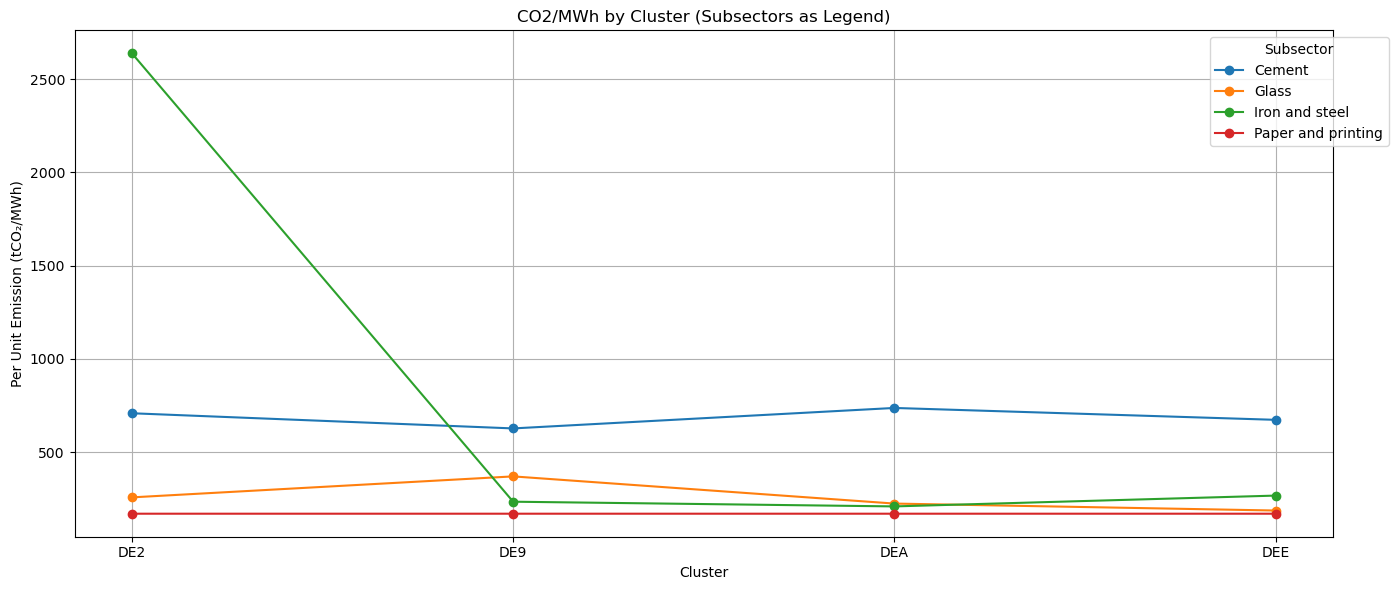

In [88]:
# Pivot the data to get clusters on x-axis and sectors as lines
pivot_df = df_grouped.pivot(index='Cluster', columns='Subsector', values='CO2/MWh')

# Plot
plt.figure(figsize=(14, 6))
for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], marker='o', label=col)

plt.title("CO2/MWh by Cluster (Subsectors as Legend)")
plt.ylabel("Per Unit Emission (tCO₂/MWh)")
plt.xlabel("Cluster")
plt.legend(title="Subsector", bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# iron has much higher per unit emission is becasue it has only one value for DE2
# Check how many non-null fuel demand entries exist for Iron and Steel in DE2
iron_de2 = df_cleaned[
    (df_cleaned['Subsector'] == 'Iron and steel') &
    (df_cleaned['Cluster'] == 'DE2')
]

# Count of non-null fuel demand values
fuel_demand_count = iron_de2['Production'].notnull().sum()
fuel_demand_count


7

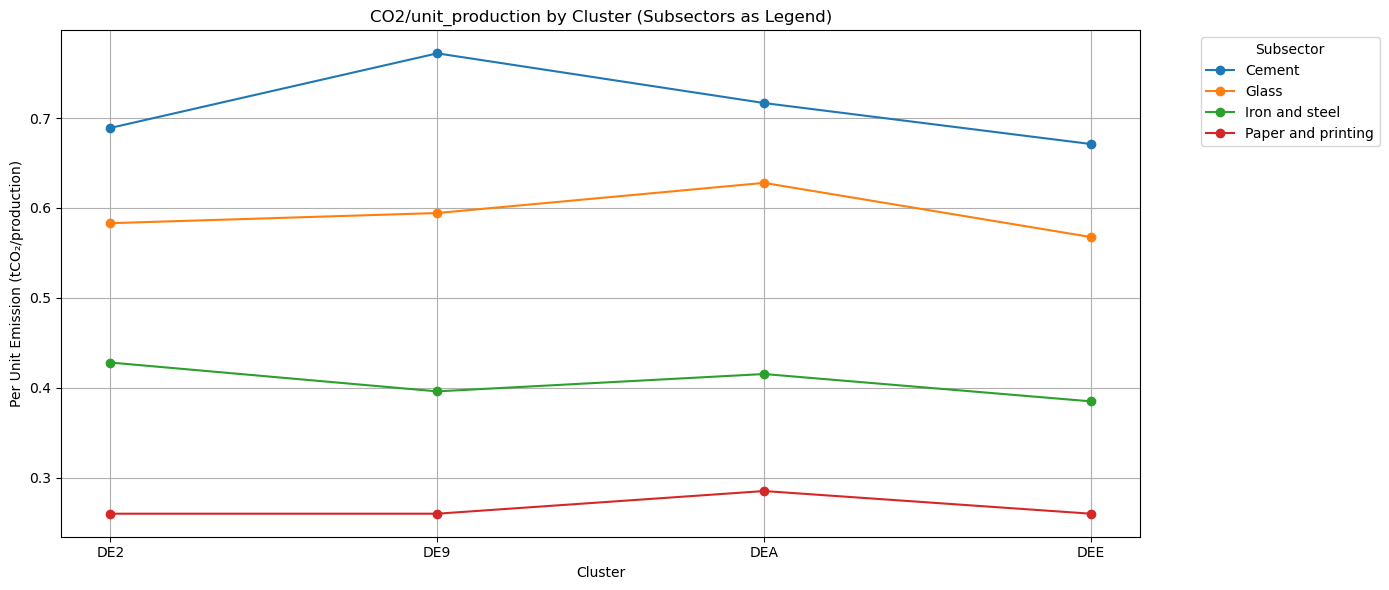

In [89]:
# Pivot the data to get clusters on x-axis and sectors as lines
pivot_df = df_grouped.pivot(index='Cluster', columns='Subsector', values='CO2/unit_production')

# Plot
plt.figure(figsize=(14, 6))
for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], marker='o', label=col)

plt.title("CO2/unit_production by Cluster (Subsectors as Legend)")
plt.ylabel("Per Unit Emission (tCO₂/production)")
plt.xlabel("Cluster")
plt.legend(title="Subsector", bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

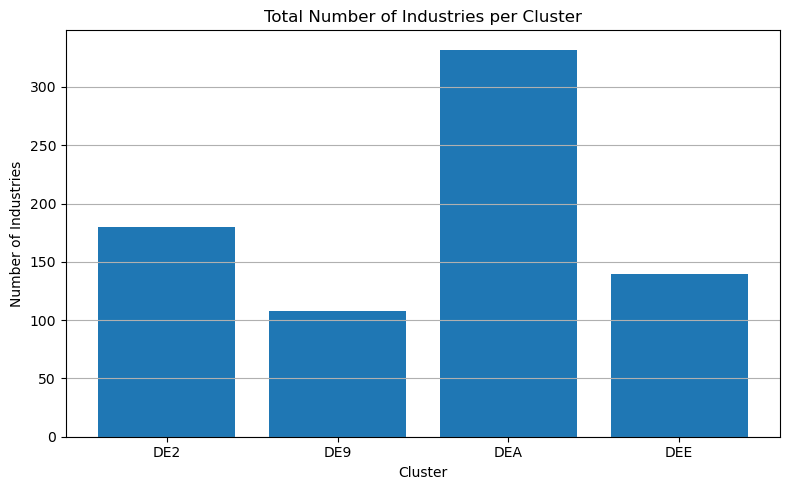

In [85]:
# Count total industries in each cluster
industries_per_cluster = df_cleaned['Cluster'].value_counts().reset_index()
industries_per_cluster.columns = ['Cluster', 'Total_Industries']
industries_per_cluster.sort_values(by='Cluster', inplace=True)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(industries_per_cluster['Cluster'], industries_per_cluster['Total_Industries'])
plt.title('Total Number of Industries per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Industries')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

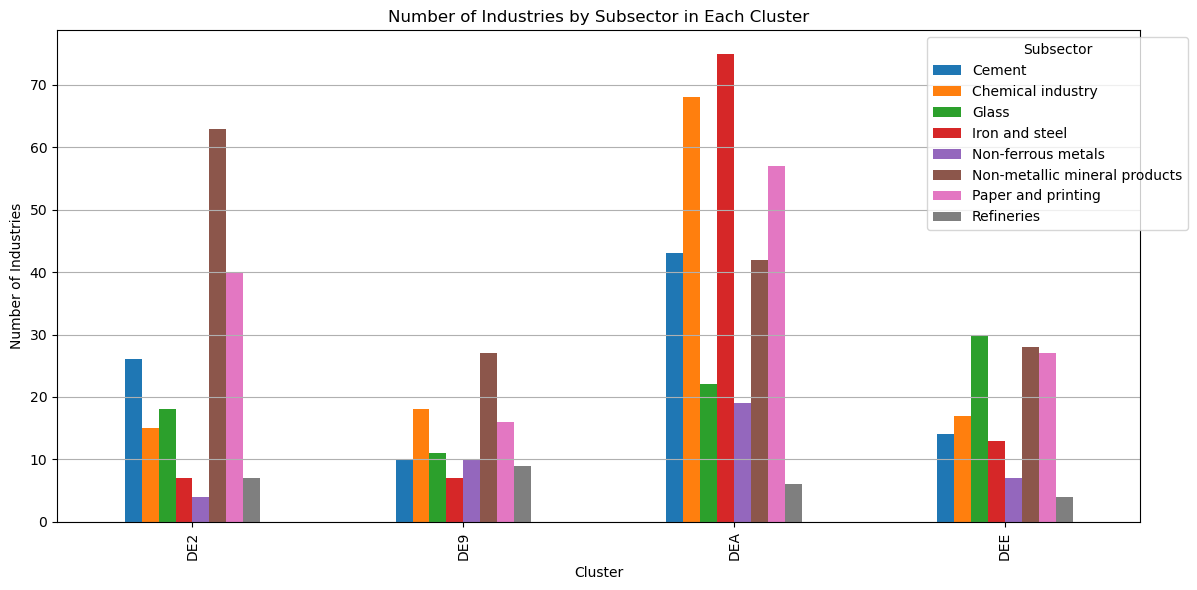

In [86]:
# Create a grouped bar chart of industry counts by subsector per cluster
industry_counts_grouped = df_cleaned.groupby(['Cluster', 'Subsector']).size().unstack(fill_value=0)

# Plot
industry_counts_grouped.plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title("Number of Industries by Subsector in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Industries")
plt.legend(title="Subsector", bbox_to_anchor=(1.05, 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()


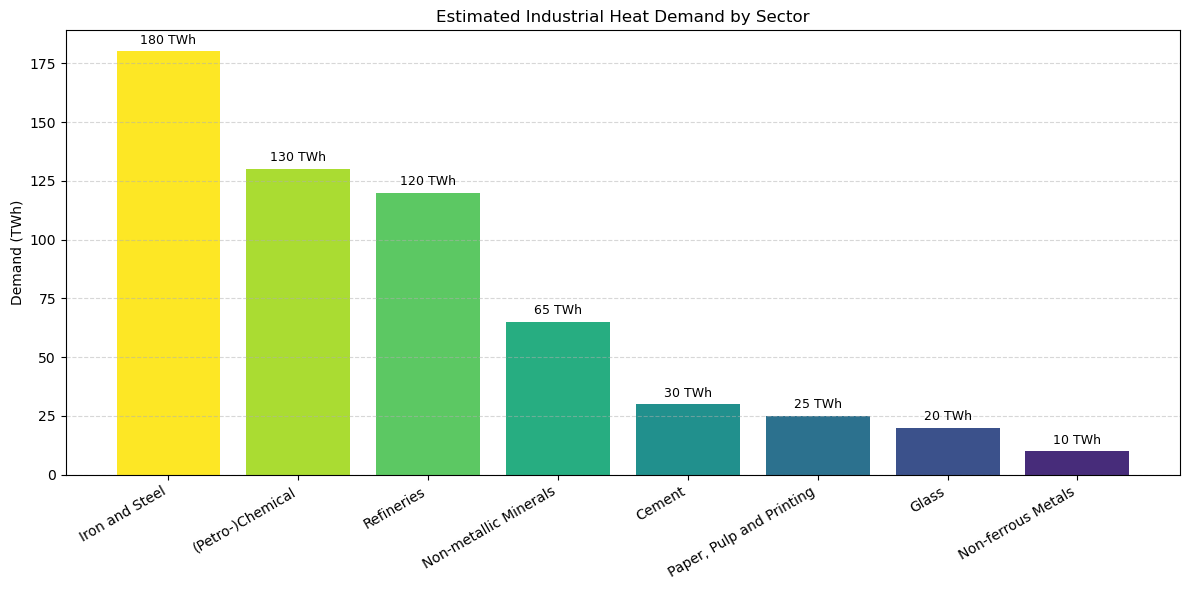

In [87]:
# Heat demand data
sector_demand = {
    '(Petro-)Chemical': 130,
    'Iron and Steel': 180,
    'Non-ferrous Metals': 10,
    'Non-metallic Minerals': 65,
    'Cement': 30,
    'Glass': 20,
    'Paper, Pulp and Printing': 25,
    'Refineries': 120
}

# Sort data by demand descending
sorted_data = dict(sorted(sector_demand.items(), key=lambda x: x[1], reverse=True))
sectors = list(sorted_data.keys())
demands = list(sorted_data.values())

# Custom colors
colors = plt.cm.viridis_r([i / len(sectors) for i in range(len(sectors))])

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(sectors, demands, color=colors)

# Add demand values on top of bars
for bar, demand in zip(bars, demands):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, f'{demand} TWh', ha='center', va='bottom', fontsize=9)

plt.title('Estimated Industrial Heat Demand by Sector')
plt.ylabel('Demand (TWh)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()